In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import zipfile

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score as sk_f1_score

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

from keras import optimizers
from keras.callbacks import Callback
from keras.models import load_model
from typing import Optional
from typeguard import typechecked
import gdown

# Data Loading

In [9]:
import gdown
!gdown https://drive.google.com/uc?id=10-b4PKd6UUTkZU3SdOn_hbgZHU8CUjT_
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

Downloading...
From (original): https://drive.google.com/uc?id=10-b4PKd6UUTkZU3SdOn_hbgZHU8CUjT_
From (redirected): https://drive.google.com/uc?id=10-b4PKd6UUTkZU3SdOn_hbgZHU8CUjT_&confirm=t&uuid=a3d8c59d-edfe-4d49-96a3-2a9246d0a4cc
To: /kaggle/working/archive.zip
100%|██████████████████████████████████████| 35.8M/35.8M [00:04<00:00, 8.72MB/s]


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_datagen = ImageDataGenerator(rescale = 1./255,
        validation_split = 0.2,
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train/',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# Dense Block

In [27]:
compression = 0.5
num_classes = 4
l = 4

def denseblock(input, num_filter=12, dropout_rate=0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter * compression), (3, 3), use_bias=False, padding='same')(relu)
        if dropout_rate > 0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        temp = layers.Concatenate(axis=-1)([temp, Conv2D_3_3])
    return temp

def transition(input, num_filter=12, dropout_rate=0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter * compression), (1, 1), use_bias=False, padding='same')(relu)
    if dropout_rate > 0:
        Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    return layers.AveragePooling2D(pool_size=(2, 2))(Conv2D_BottleNeck)

def output_layer(input):
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.GlobalAveragePooling2D()(relu)
    return layers.Dense(num_classes, activation='softmax')(AvgPooling)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

def scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1) if epoch >= 10 else lr
    tf.print("Learning Rate for epoch", epoch, ":", new_lr)
    return float(new_lr)

lr_scheduler = LearningRateScheduler(scheduler)

def create_combined_model():
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    base_model_output = base_model.output
    dense_block_output = denseblock(base_model_output, num_filter=32, dropout_rate=0.2)
    transition_block_output = transition(dense_block_output, num_filter=32, dropout_rate=0.2)
    output = output_layer(transition_block_output)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [28]:
model = create_combined_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [29]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=17,
    verbose=1,
    callbacks=[lr_scheduler]
)

model.summary()

Learning Rate for epoch 0 : 0.0010000000474974513
Epoch 1/17
  2/129 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.0859 - f1_score: 0.0000e+00 - loss: 1.5069  

I0000 00:00:1733985431.316163     196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 86s 467ms/step - accuracy: 0.3919 - f1_score: 0.0177 - loss: 1.2822 - val_accuracy: 0.5005 - val_f1_score: 0.0786 - val_loss: 1.1011 - learning_rate: 0.0010
Learning Rate for epoch 1 : 0.0010000000474974513
Epoch 2/17
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 314ms/step - accuracy: 0.5132 - f1_score: 0.3164 - loss: 1.0424 - val_accuracy: 0.5005 - val_f1_score: 0.3830 - val_loss: 1.0725 - learning_rate: 0.0010
Learning Rate for epoch 2 : 0.0010000000474974513
Epoch 3/17
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.5182 - f1_score: 0.4122 - loss: 1.0083 - val_accuracy: 0.4008 - val_f1_score: 0.0661 - val_loss: 1.1333 - learning_rate: 0.0010
Learning Rate for epoch 3 : 0.0010000000474974513
Epoch 4/17
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.5369 - f1_score: 0.4082 - loss: 0.9836 - val_accuracy: 0.4721 - val_f1_score: 0.4241 - val_loss: 1.0994 - learning_rate: 0.0010
Learning Rate for epoch 4 : 0.0010000000474974513
Epoch 5/17
129/129 ━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,353,038 (104.34 MB)

 Trainable params: 1,248,164 (4.76 MB)

 Non-trainable params: 23,608,544 (90.06 MB)

 Optimizer params: 2,496,330 (9.52 MB)

---

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

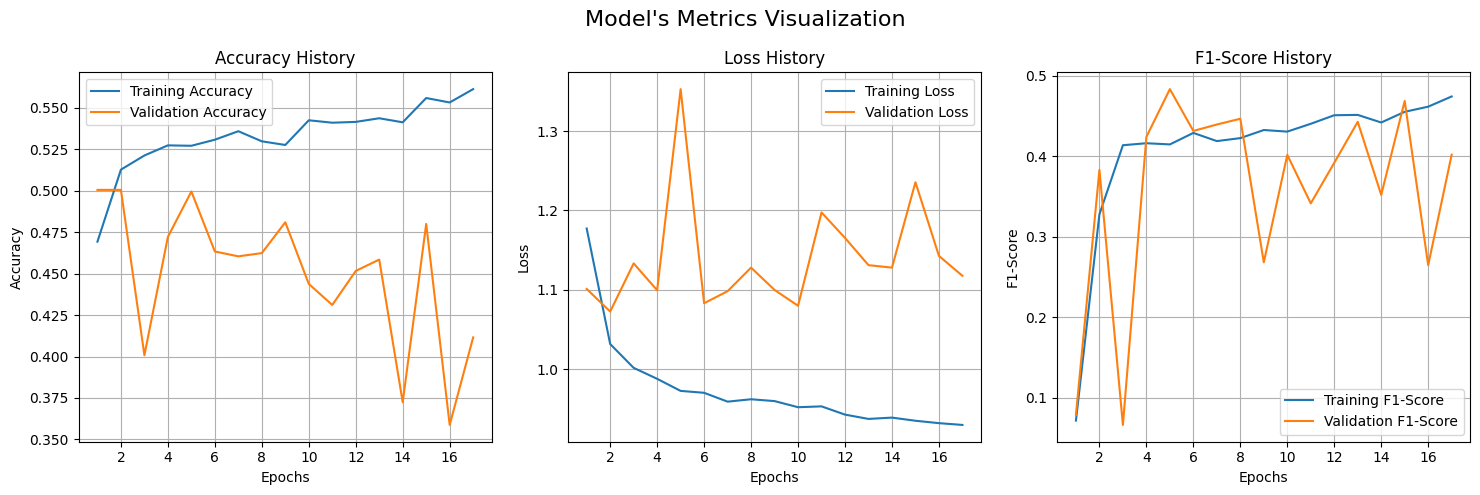

In [35]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

def Train_Val_Plot(acc, val_acc, loss, val_loss, f1, val_f1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Model's Metrics Visualization", fontsize=16)

    ax1.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    ax1.set_title('Accuracy History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(range(1, len(loss) + 1), loss, label='Training Loss')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    ax2.set_title('Loss History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(range(1, len(f1) + 1), f1, label='Training F1-Score')
    ax3.plot(range(1, len(val_f1) + 1), val_f1, label='Validation F1-Score')
    ax3.set_title('F1-Score History')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('F1-Score')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['f1_score'], history.history['val_f1_score'])

In [37]:
kpred = model.predict(test_dataset)

pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))

print(classification_report(test_dataset.classes,predictions))

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step
              precision    recall  f1-score   support

           0       0.07      0.02      0.03       179
           1       0.00      0.00      0.00        12
           2       0.50      0.74      0.59       640
           3       0.36      0.23      0.28       448

    accuracy                           0.45      1279
   macro avg       0.23      0.25      0.23      1279
weighted avg       0.39      0.45      0.40      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  msg = msg.format("in {0}s with".format(axis1))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  msg = msg.format("in {0}s with".format(axis1))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  msg = msg.format("in {0}s with".format(axis1))


# Transfer Learning

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import Counter

cudnn.benchmark = True
plt.ion()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(pretrained=True)
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

def create_transforms(is_train):
    if is_train:
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

data_dir = 'Alzheimer_s Dataset'

data_transforms = {x: create_transforms(is_train=(x == 'train')) for x in ['train', 'test']}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
    for x in ['train', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print("Class names:", class_names)
print("Number of classes:", len(class_names))
print("Dataset sizes:", dataset_sizes)

def get_label_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

train_label_distribution = get_label_distribution(image_datasets['train'])
val_label_distribution = get_label_distribution(image_datasets['test'])

print("Number of images per class in the training set:", train_label_distribution)
print("Number of images per class in the validation set:", val_label_distribution)

Using device: cuda:0
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Number of classes: 4
Dataset sizes: {'train': 5121, 'test': 1279}
Number of images per class in the training set: Counter({2: 2560, 3: 1792, 0: 717, 1: 52})
Number of images per class in the validation set: Counter({2: 640, 3: 448, 0: 179, 1: 12})


## Finetuning

In [21]:
#reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval() 

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## learning rate = 0.001

In [23]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0099 Acc: 0.5224
test Loss: 0.9155 Acc: 0.5559

Epoch 1/19
----------
train Loss: 0.8827 Acc: 0.5708
test Loss: 0.9190 Acc: 0.5606

Epoch 2/19
----------
train Loss: 0.8383 Acc: 0.6009
test Loss: 0.9272 Acc: 0.5489

Epoch 3/19
----------
train Loss: 0.8117 Acc: 0.6145
test Loss: 0.8732 Acc: 0.5895

Epoch 4/19
----------
train Loss: 0.7900 Acc: 0.6235
test Loss: 0.8870 Acc: 0.5723

Epoch 5/19
----------
train Loss: 0.7341 Acc: 0.6585
test Loss: 0.7859 Acc: 0.6333

Epoch 6/19
----------
train Loss: 0.6973 Acc: 0.6848
test Loss: 0.7799 Acc: 0.6349

Epoch 7/19
----------
train Loss: 0.6601 Acc: 0.7016
test Loss: 0.7924 Acc: 0.6443

Epoch 8/19
----------
train Loss: 0.6217 Acc: 0.7315
test Loss: 0.8142 Acc: 0.6685

Epoch 9/19
----------
train Loss: 0.5520 Acc: 0.7655
test Loss: 0.9361 Acc: 0.5973

Epoch 10/19
----------
train Loss: 0.5297 Acc: 0.7713
test Loss: 0.9215 Acc: 0.6755

Epoch 11/19
----------
train Loss: 0.5134 Acc: 0.7801
test Loss: 0.9297 Acc

## learning rate = 0.01

In [24]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft_001 = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_001 = lr_scheduler.StepLR(optimizer_ft_001, step_size=15, gamma=0.1)
model_ft_001 = train_model(model_ft, criterion, optimizer_ft_001, exp_lr_scheduler_001, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0764 Acc: 0.5136
test Loss: 0.8774 Acc: 0.4996

Epoch 1/19
----------
train Loss: 0.8626 Acc: 0.5763
test Loss: 1.6918 Acc: 0.3604

Epoch 2/19
----------
train Loss: 1.0105 Acc: 0.5347
test Loss: 0.9319 Acc: 0.5223

Epoch 3/19
----------
train Loss: 1.0043 Acc: 0.5360
test Loss: 2.2520 Acc: 0.5004

Epoch 4/19
----------
train Loss: 0.8913 Acc: 0.5626
test Loss: 10.9218 Acc: 0.3518

Epoch 5/19
----------
train Loss: 1.0885 Acc: 0.5220
test Loss: 1.7014 Acc: 0.5129

Epoch 6/19
----------
train Loss: 0.9347 Acc: 0.5499
test Loss: 1.1100 Acc: 0.3964

Epoch 7/19
----------
train Loss: 0.9870 Acc: 0.5515
test Loss: 1.2675 Acc: 0.5559

Epoch 8/19
----------
train Loss: 0.9513 Acc: 0.5569
test Loss: 0.9576 Acc: 0.5450

Epoch 9/19
----------
train Loss: 0.8858 Acc: 0.5827
test Loss: 2.4414 Acc: 0.5520

Epoch 10/19
----------
train Loss: 0.9399 Acc: 0.5714
test Loss: 1.0458 Acc: 0.5051

Epoch 11/19
----------
train Loss: 0.9209 Acc: 0.5698
test Loss: 0.9162 Ac

## learning rate = 0.1

In [25]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft_01 = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler_01 = lr_scheduler.StepLR(optimizer_ft_01, step_size=15, gamma=0.1)
model_ft_01 = train_model(model_ft, criterion, optimizer_ft_01, exp_lr_scheduler_01, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.8824 Acc: 0.4478
test Loss: 16.3948 Acc: 0.3503

Epoch 1/19
----------
train Loss: 1.1893 Acc: 0.4862
test Loss: 148052077601642304.0000 Acc: 0.5004

Epoch 2/19
----------
train Loss: 2.8810 Acc: 0.4577
test Loss: 11.3335 Acc: 0.5004

Epoch 3/19
----------
train Loss: 1.1713 Acc: 0.5079
test Loss: 72.0212 Acc: 0.3511

Epoch 4/19
----------
train Loss: 1.9425 Acc: 0.4644
test Loss: 32.1484 Acc: 0.4996

Epoch 5/19
----------
train Loss: 1.3402 Acc: 0.4503
test Loss: 1.2440 Acc: 0.3581

Epoch 6/19
----------
train Loss: 1.1162 Acc: 0.4671
test Loss: 1.0619 Acc: 0.5004

Epoch 7/19
----------
train Loss: 1.0475 Acc: 0.4804
test Loss: 1.1679 Acc: 0.5004

Epoch 8/19
----------
train Loss: 1.0457 Acc: 0.4892
test Loss: 1.0032 Acc: 0.5121

Epoch 9/19
----------
train Loss: 1.0336 Acc: 0.4989
test Loss: 1.0627 Acc: 0.4996

Epoch 10/19
----------
train Loss: 1.0374 Acc: 0.4935
test Loss: 1.0999 Acc: 0.4996

Epoch 11/19
----------
train Loss: 1.0208 Acc: 0.5040


#### accuracy

Lr 0.1 Best val Acc: 0.541830

Lr 0.01 Best val Acc: 0.591869

Lr 0.001 Best val Acc: 0.715403

Learning rate of 0.001 gives the best accuracy.

# Combined Model

In [26]:
import os
import time
from tempfile import TemporaryDirectory
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Alzheimer_s Dataset'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [28]:
compression = 0.5
num_classes = 4
l = 4

def denseblock(input, num_filter=12, dropout_rate=0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter * compression), (3, 3), use_bias=False, padding='same')(relu)
        if dropout_rate > 0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        temp = layers.Concatenate(axis=-1)([temp, Conv2D_3_3])
    return temp

def transition(input, num_filter=12, dropout_rate=0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter * compression), (1, 1), use_bias=False, padding='same')(relu)
    if dropout_rate > 0:
        Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    return layers.AveragePooling2D(pool_size=(2, 2))(Conv2D_BottleNeck)

def output_layer(input):
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.GlobalAveragePooling2D()(relu)
    return layers.Dense(num_classes, activation='softmax')(AvgPooling)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

def scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1) if epoch >= 10 else lr
    print(f"Learning Rate for epoch {epoch}: {new_lr}")
    return float(new_lr)

lr_scheduler = LearningRateScheduler(scheduler)

def create_combined_model():
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    base_model_output = base_model.output
    dense_block_output = denseblock(base_model_output, num_filter=32, dropout_rate=0.2)
    transition_block_output = transition(dense_block_output, num_filter=32, dropout_rate=0.2)
    output = output_layer(transition_block_output)

    model = Model(inputs=base_model.input, outputs=output)
    return model

keras_model = create_combined_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['class1', 'class2', 'class3', 'class4']

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_params = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_params = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_params)
    return model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [29]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer_ft, step_size=15, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.9623 Acc: 0.5411
test Loss: 0.9647 Acc: 0.5137

Epoch 1/29
----------
train Loss: 0.8766 Acc: 0.5800
test Loss: 0.8505 Acc: 0.5841

Epoch 2/29
----------
train Loss: 0.8382 Acc: 0.6096
test Loss: 0.8731 Acc: 0.5754

Epoch 3/29
----------
train Loss: 0.7823 Acc: 0.6385
test Loss: 0.8993 Acc: 0.6028

Epoch 4/29
----------
train Loss: 0.7026 Acc: 0.6889
test Loss: 0.8165 Acc: 0.6458

Epoch 5/29
----------
train Loss: 0.6600 Acc: 0.7038
test Loss: 0.7712 Acc: 0.6646

Epoch 6/29
----------
train Loss: 0.6045 Acc: 0.7295
test Loss: 1.1874 Acc: 0.5762

Epoch 7/29
----------
train Loss: 0.5446 Acc: 0.7655
test Loss: 0.7896 Acc: 0.6779

Epoch 8/29
----------
train Loss: 0.4982 Acc: 0.7895
test Loss: 0.8219 Acc: 0.7021

Epoch 9/29
----------
train Loss: 0.4565 Acc: 0.8069
test Loss: 1.0380 Acc: 0.6192

Epoch 10/29
----------
train Loss: 0.4270 Acc: 0.8264
test Loss: 1.0538 Acc: 0.6833

Epoch 11/29
----------
train Loss: 0.4269 Acc: 0.8209
test Loss: 0.8041 Acc

# Combined Model Using Weights

In [40]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [41]:
class WeightedCombinedModel(nn.Module):
    def __init__(self, model_tl, model_dense, num_classes, w1=0.5, w2=0.5):
        super(WeightedCombinedModel, self).__init__()
        self.model_tl = model_tl 
        self.model_dense = model_dense 
        self.w1 = nn.Parameter(torch.tensor(w1, requires_grad=True)) 
        self.w2 = nn.Parameter(torch.tensor(w2, requires_grad=True)) 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        output_tl = self.model_tl(x)
        output_tl = self.softmax(output_tl) 
        output_dense = self.model_dense(x)
        output_dense = self.softmax(output_dense)
        final_output = self.w1 * output_tl + self.w2 * output_dense
        return final_output

class DenseBlock(nn.Module):
    def __init__(self, input_channels, growth_rate, num_layers, dropout_rate=0.2):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_layer(input_channels + i * growth_rate, growth_rate, dropout_rate))

    def _make_layer(self, in_channels, growth_rate, dropout_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(dropout_rate)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, 1))
            features.append(new_feature)
        return torch.cat(features, 1)

class TransitionBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(TransitionBlock, self).__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.transition(x)

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes) 

    def forward(self, x):
        return self.base_model(x)

class DenseBlockModel(nn.Module):
    def __init__(self, num_classes, growth_rate=32, dense_layers=4):
        super(DenseBlockModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.dense_block = DenseBlock(num_ftrs, growth_rate, dense_layers)
        self.transition_block = TransitionBlock(num_ftrs + growth_rate * dense_layers, 256)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.dense_block(x)
        x = self.transition_block(x)
        return self.classifier(x)

In [42]:
num_classes = len(class_names)
tl_model = TransferLearningModel(num_classes)
dense_model = DenseBlockModel(num_classes, growth_rate=16, dense_layers=2)

tl_model = tl_model.to(device)
dense_model = dense_model.to(device)

combined_model = WeightedCombinedModel(tl_model, dense_model, num_classes, w1=0.6, w2=0.4)
combined_model = combined_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(combined_model.parameters(), lr=0.001, momentum=0.9)

scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model.train() 
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print("Training Complete!")
    return model

In [45]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='Alzheimer_s Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Alzheimer_s Dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [46]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, device='cuda'):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase, loader in [('train', train_loader), ('val', val_loader)]:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()  

                running_loss = 0.0
                running_corrects = 0

                for batch in loader:
                    inputs, labels = batch[:2]
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(loader.dataset)
                epoch_acc = running_corrects.double() / len(loader.dataset)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='Alzheimer_s Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Alzheimer_s Dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(224 * 224 * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_dataset.classes))
).to('cuda')

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0338 Acc: 0.4919
val Loss: 1.0887 Acc: 0.3503

Epoch 1/19
----------
train Loss: 1.0106 Acc: 0.5085
val Loss: 1.1193 Acc: 0.5004

Epoch 2/19
----------
train Loss: 0.9820 Acc: 0.5091
val Loss: 0.9864 Acc: 0.5121

Epoch 3/19
----------
train Loss: 0.9834 Acc: 0.5071
val Loss: 1.0148 Acc: 0.5012

Epoch 4/19
----------
train Loss: 0.9942 Acc: 0.4896
val Loss: 1.0223 Acc: 0.5004

Epoch 5/19
----------
train Loss: 1.0573 Acc: 0.4653
val Loss: 1.0067 Acc: 0.5004

Epoch 6/19
----------
train Loss: 1.0433 Acc: 0.4819
val Loss: 1.1204 Acc: 0.5004

Epoch 7/19
----------
train Loss: 0.9965 Acc: 0.4956
val Loss: 0.9903 Acc: 0.5020

Epoch 8/19
----------
train Loss: 1.0308 Acc: 0.4759
val Loss: 1.1348 Acc: 0.5004

Epoch 9/19
----------
train Loss: 1.0037 Acc: 0.4919
val Loss: 0.9908 Acc: 0.5020

Epoch 10/19
----------
train Loss: 1.0282 Acc: 0.4722
val Loss: 1.0369 Acc: 0.5004

Epoch 11/19
----------
train Loss: 1.0475 Acc: 0.4316
val Loss: 0.9944 Acc: 0.5082

Ep

/tmp/ipykernel_23/4088394658.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))
